# Сценарий

Для сценария есть смысл получать кварталы буквально на этапе создания сценария.

ВАЖНО: 
- Кварталы сценария получаем для выбранного `scenario_id`.
- Стараемся работать в `crs` от `project_boundaries`.

In [1]:
import geopandas as gpd
import pandas as pd
import prostor.fetchers.projects as projects
import prostor.fetchers.scenarios as scenarios
import prostor.fetchers.territories as territories
from blocksnet.config import log_config

log_config.set_logger_level('WARNING')

In [2]:
SCENARIO_ID = 615 #610 тоже хороший сценарий

## Вспомогательный код

### 1. Получение слоя городских кварталов

Метод `close_gaps` необходим для дружбы геометрий дорог, которые граничат рядом но не соприкасаются на перекрестках точь-в-точь.

Так как мы не хотим цеплять всю библиотеку `momepy` ради одного метода, мы просто честно его скопируем.

In [3]:
import shapely
import numpy as np

def close_gaps(gdf, tolerance): # taken from momepy
    geom = gdf.geometry.array
    coords = shapely.get_coordinates(geom)
    indices = shapely.get_num_coordinates(geom)

    edges = [0]
    i = 0
    for ind in indices:
        ix = i + ind
        edges.append(ix - 1)
        edges.append(ix)
        i = ix
    edges = edges[:-1]
    points = shapely.points(np.unique(coords[edges], axis=0))

    buffered = shapely.buffer(points, tolerance / 2)

    dissolved = shapely.union_all(buffered)

    exploded = [
        shapely.get_geometry(dissolved, i)
        for i in range(shapely.get_num_geometries(dissolved))
    ]

    centroids = shapely.centroid(exploded)

    snapped = shapely.snap(geom, shapely.union_all(centroids), tolerance)

    return gpd.GeoSeries(snapped, crs=gdf.crs)

In [4]:
from blocksnet.blocks.cutting import preprocess_urban_objects, cut_urban_blocks

BUILDING_POF_ID = 1
WATER_POF_ID = 4
ROADS_POF_ID = 26

LIVING_BUILDING_POT_ID = 4

def _get_project_boundaries(project_id : int):
    return gpd.GeoDataFrame(geometry=[projects.get_project_geometry(project_id)], crs=4326)

def _get_scenario_roads(scenario_id : int):
    gdf = scenarios.get_physical_objects(scenario_id, physical_object_function_id=ROADS_POF_ID)
    return gdf[['geometry']].reset_index(drop=True)

def _get_scenario_water(scenario_id : int):
    gdf = scenarios.get_physical_objects(scenario_id, physical_object_function_id=WATER_POF_ID)
    return gdf[['geometry']].reset_index(drop=True)

def _get_scenario_blocks(user_scenario_id : int, base_scenario_id : int, boundaries : gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    crs = boundaries.crs
    boundaries.geometry = boundaries.buffer(-1)

    water = _get_scenario_water(user_scenario_id).to_crs(crs)
    user_roads = _get_scenario_roads(user_scenario_id).to_crs(crs)
    base_roads = _get_scenario_roads(base_scenario_id).to_crs(crs)
    roads = pd.concat([user_roads, base_roads]).reset_index(drop=True)
    roads.geometry = close_gaps(roads, 1)

    lines, polygons = preprocess_urban_objects(roads, None, water)
    blocks = cut_urban_blocks(boundaries, lines, polygons)
    return blocks

def _get_scenario_info(scenario_id : int) -> tuple[int, int]:
    scenario = scenarios.get_scenario(scenario_id)
    project_id = scenario['project']['project_id']
    project = projects.get_project(project_id)
    base_scenario_id = project['base_scenario']['id']
    return project_id, base_scenario_id

def get_scenario_blocks(user_scenario_id : int):
    project_id, base_scenario_id = _get_scenario_info(user_scenario_id)
    project_boundaries = _get_project_boundaries(project_id)

    crs = project_boundaries.estimate_utm_crs()
    project_boundaries = project_boundaries.to_crs(crs)

    return _get_scenario_blocks(user_scenario_id, base_scenario_id, project_boundaries)

2025-05-31 20:21:54.940 | WARNING  | blocksnet.blocks.cutting.preprocessing.core:preprocess_urban_objects:53 - Railways GeoDataFrame is None. Creating empty


<Axes: >

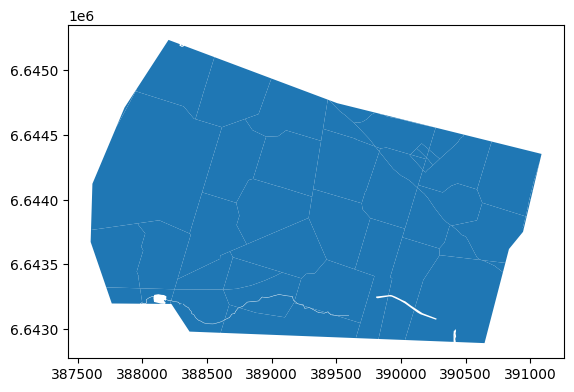

In [5]:
get_scenario_blocks(SCENARIO_ID).plot()

### 2. Получение слоя функциональных зон

P.S: Я до конца не уверен, какие именно ФЗ из БД нужны изначальные.

In [6]:
from prostor.adapters import adapt_functional_zones

SOURCES_PRIORITY = ['User', 'PZZ', 'OSM']

def _get_best_functional_zones_source(sources_df : pd.DataFrame) -> tuple[int | None, str | None]:
    sources = sources_df['source'].unique()
    for source in SOURCES_PRIORITY:
        if source in sources:
            sources_df = sources_df[sources_df['source'] == source]
            year = sources_df.year.max()
            return int(year), source
    return None, None #FIXME ??? 

def get_scenario_functional_zones(scenario_id : int) -> gpd.GeoDataFrame:
    sources_df = scenarios.get_functional_zones_sources(scenario_id)
    year, source = _get_best_functional_zones_source(sources_df)
    functional_zones = scenarios.get_functional_zones(scenario_id, year, source)
    return adapt_functional_zones(functional_zones)

### 3. Получение слоя зданий

Если зданий нет, то вернется `None` и мы это отработаем потом.

In [7]:
from prostor.adapters import adapt_buildings
from blocksnet.preprocessing.imputing import impute_buildings

def get_scenario_buildings(scenario_id : int):
    try:
        gdf = scenarios.get_physical_objects(scenario_id, physical_object_type_id=LIVING_BUILDING_POT_ID, centers_only=True)
    except:
        return None
    gdf = adapt_buildings(gdf.reset_index(drop=True))
    crs = gdf.estimate_utm_crs()
    return impute_buildings(gdf.to_crs(crs)).to_crs(4326)

### 4. Получение слоев сервисов

In [8]:
from prostor.adapters import adapt_services
from blocksnet.preprocessing.imputing import impute_services

def get_scenario_services(scenario_id : int, service_types : pd.DataFrame):
    try:
        gdf = scenarios.get_services(scenario_id, centers_only=True)
    except:
        return {}
    gdfs = adapt_services(gdf.reset_index(drop=True), service_types)
    return {st:impute_services(gdf,st) for st,gdf in gdfs.items()}

## Пайплайн

### 1. Получение слоя городских кварталов

In [9]:
blocks = get_scenario_blocks(SCENARIO_ID)
blocks.head()

2025-05-31 20:21:56.840 | WARNING  | blocksnet.blocks.cutting.preprocessing.core:preprocess_urban_objects:53 - Railways GeoDataFrame is None. Creating empty


,geometry
0,"POLYGON ((388511.373 6644951.946, 388558.037 6..."
1,"POLYGON ((388558.037 6645102.374, 388511.373 6..."
2,"POLYGON ((387957.434 6643444.937, 388007.492 6..."
3,"POLYGON ((388007.492 6643608.409, 387957.434 6..."
4,"POLYGON ((388001.306 6643195.969, 388000.75 66..."


<Axes: >

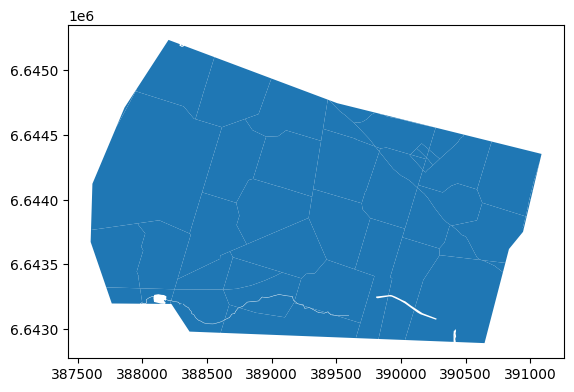

In [10]:
blocks.plot()

### 2. Получение слоя функциональных зон

In [11]:
from prostor.adapters import LAND_USE_RULES
from blocksnet.blocks.assignment import assign_land_use

functional_zones = get_scenario_functional_zones(SCENARIO_ID).to_crs(blocks.crs)
blocks_lu = assign_land_use(blocks, functional_zones, LAND_USE_RULES)
blocks_lu.head()

,geometry,residential,business,recreation,industrial,transport,special,agriculture,land_use,share
0,"POLYGON ((388511.373 6644951.946, 388558.037 6...",0.000000,0.000000,0.0,0.0,0.000000,0.0,0.91818,LandUse.AGRICULTURE,0.918180
1,"POLYGON ((388558.037 6645102.374, 388511.373 6...",0.000000,0.938081,0.0,0.0,0.000000,0.0,0.00000,LandUse.BUSINESS,0.938081
2,"POLYGON ((387957.434 6643444.937, 388007.492 6...",0.000000,0.000000,0.0,0.0,0.891381,0.0,0.00000,LandUse.TRANSPORT,0.891381
3,"POLYGON ((388007.492 6643608.409, 387957.434 6...",0.934862,0.000000,0.0,0.0,0.000000,0.0,0.00000,LandUse.RESIDENTIAL,0.934862
4,"POLYGON ((388001.306 6643195.969, 388000.75 66...",0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00000,None,NaN


In [12]:
blocks = blocks.join(blocks_lu.drop(columns=['geometry']))
blocks.head()

,geometry,residential,business,recreation,industrial,transport,special,agriculture,land_use,share
0,"POLYGON ((388511.373 6644951.946, 388558.037 6...",0.000000,0.000000,0.0,0.0,0.000000,0.0,0.91818,LandUse.AGRICULTURE,0.918180
1,"POLYGON ((388558.037 6645102.374, 388511.373 6...",0.000000,0.938081,0.0,0.0,0.000000,0.0,0.00000,LandUse.BUSINESS,0.938081
2,"POLYGON ((387957.434 6643444.937, 388007.492 6...",0.000000,0.000000,0.0,0.0,0.891381,0.0,0.00000,LandUse.TRANSPORT,0.891381
3,"POLYGON ((388007.492 6643608.409, 387957.434 6...",0.934862,0.000000,0.0,0.0,0.000000,0.0,0.00000,LandUse.RESIDENTIAL,0.934862
4,"POLYGON ((388001.306 6643195.969, 388000.75 66...",0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00000,None,NaN


### 3. Получение слоя зданий 

In [13]:
from blocksnet.blocks.aggregation import aggregate_objects

buildings = get_scenario_buildings(SCENARIO_ID)
if buildings is not None:
    buildings = buildings.to_crs(blocks.crs)
    blocks_buildings, _ = aggregate_objects(blocks, buildings)
    blocks = blocks.join(blocks_buildings.drop(columns=['geometry']).rename(columns={'objects_count' : 'count_buildings'}))
    blocks['count_buildings'] = blocks['count_buildings'].fillna(0).astype(int)

In [14]:
blocks.head()

,geometry,residential,business,recreation,industrial,transport,special,agriculture,land_use,share
0,"POLYGON ((388511.373 6644951.946, 388558.037 6...",0.000000,0.000000,0.0,0.0,0.000000,0.0,0.91818,LandUse.AGRICULTURE,0.918180
1,"POLYGON ((388558.037 6645102.374, 388511.373 6...",0.000000,0.938081,0.0,0.0,0.000000,0.0,0.00000,LandUse.BUSINESS,0.938081
2,"POLYGON ((387957.434 6643444.937, 388007.492 6...",0.000000,0.000000,0.0,0.0,0.891381,0.0,0.00000,LandUse.TRANSPORT,0.891381
3,"POLYGON ((388007.492 6643608.409, 387957.434 6...",0.934862,0.000000,0.0,0.0,0.000000,0.0,0.00000,LandUse.RESIDENTIAL,0.934862
4,"POLYGON ((388001.306 6643195.969, 388000.75 66...",0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00000,None,NaN


### 4. Получение слоев сервисов

In [15]:
service_types = pd.read_pickle('./data/service_types.pickle')
services_dict = get_scenario_services(SCENARIO_ID, service_types)

In [18]:
for service_type, services in services_dict.items():
    services = services.to_crs(blocks.crs)
    blocks_services, _ = aggregate_objects(blocks, services)
    blocks_services['capacity'] = blocks_services['capacity'].fillna(0).astype(int)
    blocks_services['objects_count'] = blocks_services['objects_count'].fillna(0).astype(int)
    blocks = blocks.join(blocks_services.drop(columns=['geometry']).rename(columns={
        'capacity': f'capacity_{service_type}',
        'objects_count': f'count_{service_type}',
    }))

In [19]:
blocks.head()

,geometry,residential,business,recreation,industrial,transport,special,agriculture,land_use,share
0,"POLYGON ((388511.373 6644951.946, 388558.037 6...",0.000000,0.000000,0.0,0.0,0.000000,0.0,0.91818,LandUse.AGRICULTURE,0.918180
1,"POLYGON ((388558.037 6645102.374, 388511.373 6...",0.000000,0.938081,0.0,0.0,0.000000,0.0,0.00000,LandUse.BUSINESS,0.938081
2,"POLYGON ((387957.434 6643444.937, 388007.492 6...",0.000000,0.000000,0.0,0.0,0.891381,0.0,0.00000,LandUse.TRANSPORT,0.891381
3,"POLYGON ((388007.492 6643608.409, 387957.434 6...",0.934862,0.000000,0.0,0.0,0.000000,0.0,0.00000,LandUse.RESIDENTIAL,0.934862
4,"POLYGON ((388001.306 6643195.969, 388000.75 66...",0.000000,0.000000,0.0,0.0,0.000000,0.0,0.00000,None,NaN


## Результат

В результате получаем слой со столбцами со всех этапов пайплайна:
- **Геометрии кварталов**.
- **Функциональное зонирование** -- доли `residential`, `recreation` и тд, а также наибольший `land_use` и его доля `share`
- **Параметры зданий** (по возможности) -- `population`, `build_floor_area`, `buildings_count` и тд.
- **Параметры сервисов** (по возможности) -- `capacity_{service_type}` и `count_{service_type}`

In [20]:
blocks.to_pickle('./data/scenario_blocks.pickle')

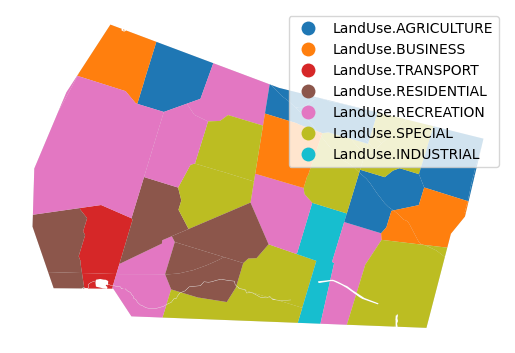

In [21]:
ax = blocks.plot(color='#ddd')
blocks.plot(column='land_use', ax=ax, legend=True).set_axis_off()